In [1]:
import json
import os
import warnings
from datetime import datetime

import pandas as pd
import torch
from torch.utils.data import DataLoader

from datasets.SlideSeperatedCSVDataset import SlideSeperatedCSVDataset
from extractors.TemplateMatchExtractor import TemplateMatchExtractor, generate_dataset_from_slides
from labelers.GroundTruthLabeler import GroundTruthLabeler
from models.mlp import MLPBinaryClassifier
from models.resnet import Resnet18BinaryClassifier, Resnet50BinaryClassifier, Resnet101BinaryClassifier
from test import test_classifier
from train import train_classifier
from utils import extract_features_from_dataset
from utils import plot_model_metrics
from utils import split_dataset


In [2]:
slides_root_dir = "data/whole-slides/gut"
labels_root_dir = "data/labels"
candidates_dataset_dir = "output/candidates"
model_output_dir = "output/models"
PretrainedModelClass = Resnet101BinaryClassifier
pretrained_model_name = PretrainedModelClass.get_pretrained_model_name()
pretrained_output_size = PretrainedModelClass.pretrained_output_size
features_csv_file_name = f"{PretrainedModelClass.get_pretrained_model_name()}_{pretrained_output_size}_features.csv"
print(f"{pretrained_model_name}: {pretrained_output_size} features")

Resnet101: 2048 features


In [3]:
ground_truth_labeler = GroundTruthLabeler(f"{labels_root_dir}/slide-annotations/all.json",
                                          f"{labels_root_dir}/patch-classifications.csv")
extractor = TemplateMatchExtractor(ground_truth_labeler)
generate_dataset_from_slides(slides_root_dir, extractor, candidates_dataset_dir)

Found cached candidates dataset output/candidates


In [4]:
extract_features_from_dataset(candidates_dataset_dir,
                              [Resnet18BinaryClassifier, Resnet50BinaryClassifier, Resnet101BinaryClassifier])

Device: cuda:0
Found cached output/candidates/Resnet18_512_features.csv
Found cached output/candidates/Resnet50_2048_features.csv
Found cached output/candidates/Resnet101_2048_features.csv


In [5]:
def split_data(dataframe, train_portion=0.7):
    train_set = pd.DataFrame()
    test_set = pd.DataFrame()
    for category in dataframe['quartile'].unique():
        category_slides = dataframe[dataframe['quartile'] == category]
        train_samples = category_slides.sample(frac=train_portion)
        test_samples = category_slides.drop(train_samples.index)
        train_set = pd.concat([train_set, train_samples])
        test_set = pd.concat([test_set, test_samples])
    return train_set, test_set


if os.path.exists("output/models/data-split.json"):
    with open(f"{model_output_dir}/data-split.json", 'r') as f:
        backup = json.load(f)
    slides_df = ground_truth_labeler.positive_regions_summary
    train_slides, test_slides = set(backup["train_slides"]), set(backup["test_slides"])
    if train_slides.union(test_slides) != set(slides_df["slide_name"]) or len(
            train_slides.intersection(test_slides)) > 0:
        raise ValueError("Invalid train test split")
    train_slides = slides_df[slides_df['slide_name'].isin(train_slides)]
    test_slides = slides_df[slides_df['slide_name'].isin(test_slides)]
else:
    slides_df = ground_truth_labeler.positive_regions_summary
    train_slides, test_slides = split_data(slides_df)
    with open(f"{model_output_dir}/data-split.json", 'w') as f:
        json.dump({
            "train_slides": list(train_slides["slide_name"]),
            "test_slides": list(test_slides["slide_name"])
        }, f)

print("Train Slides")
train_slides

Train Slides


,slide_name,n_gt_positive_regions,category
0,522934,203,4
1,593448,13,1
2,593451,1,1
3,593452,336,4
4,593454,22,2
9,593445,107,4
10,593438,92,3
12,593447,25,2
13,593441,4,1
14,593449,284,4


In [6]:
print("Test Slides")
test_slides

Test Slides


,slide_name,n_gt_positive_regions,category
5,593435,109,4
6,593446,15,1
7,593434,27,2
8,593436,170,4
11,522021,3,1
15,593437,94,3
19,593453,19,2


In [7]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

batch_size = 4096
# dataset = SlideSeperatedImageDataset(candidates_dataset_dir, set(train_slides["slide_name"]))
dataset = SlideSeperatedCSVDataset(f"{candidates_dataset_dir}/{features_csv_file_name}",
                                   set(train_slides["slide_name"]))
# dataset = reduce_dataset(dataset, discard_ratio=0.0)

print(f"All dataset: {int(sum(dataset.labels)):,} positive, {len(dataset.labels):,} negative")


Device: cuda:0
All dataset: 702 positive, 71,534 negative


In [8]:
train_dataset, validation_dataset = split_dataset(dataset, train_ratio=0.9)
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
validation_loader = DataLoader(validation_dataset,
                               batch_size=batch_size,
                               shuffle=True, )
print(f"Dataset: {len(train_dataset):,} training, {len(validation_dataset):,} validation")
print(f"Training: {int(sum(train_dataset.labels)):,d} positive, {len(train_dataset.labels):,} negative")
print(f"Validation: {int(sum(validation_dataset.labels)):,d} positive, {len(validation_dataset.labels):,} negative")

Dataset: 64,380 training, 7,154 validation
Training: 632 positive, 64,380 negative
Validation: 70 positive, 7,154 negative


In [9]:
# (hidden_layers=1, units=2048, dropout=0.1, threshold=0.5, learning_rate=3e-05, weight_decay=0.0, focal_alpha=0.75, focal_gamma=2.5)
model = MLPBinaryClassifier(in_features=pretrained_output_size, hidden_layers=1,
                            units_per_layer=2048,
                            dropout=0.1, focal_alpha=0.75, focal_gamma=2.5)

print(model)

MLPBinaryClassifier(
  (model): Sequential(
    (0): Linear(in_features=2048, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=2048, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [10]:
print(f"Training starts {datetime.now().isoformat()}")

Training starts 2025-02-09T13:12:46.802859


In [11]:

model = model.to(device)
model, model_metrics = train_classifier(model, train_loader, validation_loader, device,
                                        start_learning_rate=0.000030,
                                        min_learning_rate=0.000010,
                                        lr_warmup_steps=10,
                                        max_epochs=30,
                                        checkpoint_every=1,
                                        eval_every=1,
                                        early_stopper=None  #EarlyStopper(patience=5, min_delta=1e-4))
                                        )

Epoch 1 training: 100%|██████████| 16/16 [00:02<00:00,  7.53it/s]


Train: 1/30: lr: 0.000030000000 loss:0.013896515301894397


Epoch 1 testing: 100%|██████████| 2/2 [00:00<00:00,  9.64it/s]


Test: 1/30: loss:0.007651586318388581, accuracy:0.9902534559710187, precision:0.0, recall:0.0, f1:0.0, mcc:0.0, ece:0.22326551377773285, pr_auc:0.011691981435765098, epoch:1


Epoch 2 training: 100%|██████████| 16/16 [00:01<00:00,  8.39it/s]


Train: 2/30: lr: 0.000030000000 loss:0.007381214410997927


Epoch 2 testing: 100%|██████████| 2/2 [00:00<00:00, 10.20it/s]


Test: 2/30: loss:0.006782672600820661, accuracy:0.9902120207243297, precision:0.0, recall:0.0, f1:0.0, mcc:0.0, ece:0.20360919833183289, pr_auc:0.03372585121388909, epoch:2


Epoch 3 training: 100%|██████████| 16/16 [00:01<00:00,  8.07it/s]


Train: 3/30: lr: 0.000030000000 loss:0.006077368569094688


Epoch 3 testing: 100%|██████████| 2/2 [00:00<00:00,  9.15it/s]


Test: 3/30: loss:0.005780757870525122, accuracy:0.9902120207243297, precision:0.0, recall:0.0, f1:0.0, mcc:0.0, ece:0.22195900231599808, pr_auc:0.09511493400741407, epoch:3


Epoch 4 training: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]


Train: 4/30: lr: 0.000030000000 loss:0.005280321289319545


Epoch 4 testing: 100%|██████████| 2/2 [00:00<00:00,  7.21it/s]


Test: 4/30: loss:0.005230169277638197, accuracy:0.9898805387508176, precision:0.0, recall:0.0, f1:0.0, mcc:0.0, ece:0.1877061128616333, pr_auc:0.1236223396763215, epoch:4


Epoch 5 training: 100%|██████████| 16/16 [00:02<00:00,  6.13it/s]


Train: 5/30: lr: 0.000030000000 loss:0.004576561841531657


Epoch 5 testing: 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]


Test: 5/30: loss:0.0046049675438553095, accuracy:0.9902120207243297, precision:0.0, recall:0.0, f1:0.0, mcc:0.0, ece:0.1766899824142456, pr_auc:0.15840024435400898, epoch:5


Epoch 6 training: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s]


Train: 6/30: lr: 0.000030000000 loss:0.00417297771491576


Epoch 6 testing: 100%|██████████| 2/2 [00:00<00:00,  8.00it/s]


Test: 6/30: loss:0.004276549210771918, accuracy:0.9898435743592626, precision:0.125, recall:0.016129032258064516, f1:0.028571428571428574, mcc:0.043328987873744666, ece:0.15983912348747253, pr_auc:0.1599418717260323, epoch:6


Epoch 7 training: 100%|██████████| 16/16 [00:02<00:00,  6.29it/s]


Train: 7/30: lr: 0.000030000000 loss:0.003918442642316222


Epoch 7 testing: 100%|██████████| 2/2 [00:00<00:00,  7.53it/s]


Test: 7/30: loss:0.004030957818031311, accuracy:0.9899286802802076, precision:0.16666666666666666, recall:0.011363636363636364, f1:0.021276595744680854, mcc:0.04117601430018345, ece:0.13916436582803726, pr_auc:0.1839715031166334, epoch:7


Epoch 8 training: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s]


Train: 8/30: lr: 0.000030000000 loss:0.0037411259254440665


Epoch 8 testing: 100%|██████████| 2/2 [00:00<00:00,  7.37it/s]


Test: 8/30: loss:0.003965736948885024, accuracy:0.9895165632408846, precision:0.4083333333333333, recall:0.1298116298116298, f1:0.19621749408983452, mcc:0.2254978018297299, ece:0.14016710966825485, pr_auc:0.1966119862084995, epoch:8


Epoch 9 training: 100%|██████████| 16/16 [00:02<00:00,  6.12it/s]


Train: 9/30: lr: 0.000030000000 loss:0.003582782330340706


Epoch 9 testing: 100%|██████████| 2/2 [00:00<00:00,  7.43it/s]


Test: 9/30: loss:0.0037984660593792796, accuracy:0.9897237394743297, precision:0.38541666666666663, recall:0.11904761904761904, f1:0.17951318458417848, mcc:0.20824420280886674, ece:0.1301618218421936, pr_auc:0.2139852316261348, epoch:9


Epoch 10 training: 100%|██████████| 16/16 [00:02<00:00,  6.11it/s]


Train: 10/30: lr: 0.000029510565 loss:0.003455316895269789


Epoch 10 testing: 100%|██████████| 2/2 [00:00<00:00,  7.07it/s]


Test: 10/30: loss:0.003768518567085266, accuracy:0.9891917875500735, precision:0.38675213675213677, recall:0.17038875103391232, f1:0.2364433811802233, mcc:0.2518987463912002, ece:0.13060622662305832, pr_auc:0.23013079751486493, epoch:10


Epoch 11 training: 100%|██████████| 16/16 [00:02<00:00,  5.88it/s]


Train: 11/30: lr: 0.000028090170 loss:0.0033307920821243897


Epoch 11 testing: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]


Test: 11/30: loss:0.003524755476973951, accuracy:0.9890741880927076, precision:0.41666666666666663, recall:0.24404761904761904, f1:0.3055555555555556, mcc:0.3124765927644507, ece:0.1312151700258255, pr_auc:0.2662816808137606, epoch:11


Epoch 12 training: 100%|██████████| 16/16 [00:02<00:00,  5.90it/s]


Train: 12/30: lr: 0.000025877853 loss:0.0032348192034987733


Epoch 12 testing: 100%|██████████| 2/2 [00:00<00:00,  4.98it/s]


Test: 12/30: loss:0.003527400433085859, accuracy:0.9887012708725065, precision:0.38011695906432746, recall:0.25, f1:0.301553457203777, mcc:0.30277129497632316, ece:0.1300569325685501, pr_auc:0.2628871262471097, epoch:12


Epoch 13 training: 100%|██████████| 16/16 [00:02<00:00,  5.47it/s]


Train: 13/30: lr: 0.000023090170 loss:0.003091324309934862


Epoch 13 testing: 100%|██████████| 2/2 [00:00<00:00,  9.07it/s]


Test: 13/30: loss:0.0035425692331045866, accuracy:0.9893552931092626, precision:0.4416475972540046, recall:0.255718954248366, f1:0.3228070175438597, mcc:0.3304911687341022, ece:0.12301447987556458, pr_auc:0.3001032069172365, epoch:13


Epoch 14 training: 100%|██████████| 16/16 [00:02<00:00,  7.59it/s]


Train: 14/30: lr: 0.000020000000 loss:0.003010432206792757


Epoch 14 testing: 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


Test: 14/30: loss:0.0034924409119412303, accuracy:0.9893116224350065, precision:0.4342105263157895, recall:0.25411184210526316, f1:0.3205882352941176, mcc:0.3271418917365044, ece:0.11928411573171616, pr_auc:0.3185092811086283, epoch:14


Epoch 15 training: 100%|██████████| 16/16 [00:02<00:00,  6.48it/s]


Train: 15/30: lr: 0.000016909830 loss:0.0029066582064842805


Epoch 15 testing: 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


Test: 15/30: loss:0.00341556069906801, accuracy:0.9905804670893967, precision:0.5083333333333333, recall:0.23333333333333334, f1:0.31975051975051977, mcc:0.34027631459259255, ece:0.11278566718101501, pr_auc:0.3123428788974264, epoch:15


Epoch 16 training: 100%|██████████| 16/16 [00:02<00:00,  5.57it/s]


Train: 16/30: lr: 0.000014122147 loss:0.002827947522746399


Epoch 16 testing: 100%|██████████| 2/2 [00:00<00:00,  9.19it/s]


Test: 16/30: loss:0.00326895690523088, accuracy:0.9898458097868297, precision:0.45806451612903226, recall:0.3356643356643357, f1:0.38724637681159424, mcc:0.3870481299004894, ece:0.11891671642661095, pr_auc:0.31219802622882387, epoch:16


Epoch 17 training: 100%|██████████| 16/16 [00:02<00:00,  7.44it/s]


Train: 17/30: lr: 0.000011909830 loss:0.0027582176408031955


Epoch 17 testing: 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


Test: 17/30: loss:0.0034421986201778054, accuracy:0.9907854078952747, precision:0.5496323529411764, recall:0.26716294458229944, f1:0.35904255319148937, mcc:0.37890092676419984, ece:0.10816167667508125, pr_auc:0.37039638307981776, epoch:17


Epoch 18 training: 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]


Train: 18/30: lr: 0.000010489435 loss:0.002715097027248703


Epoch 18 testing: 100%|██████████| 2/2 [00:00<00:00,  8.77it/s]


Test: 18/30: loss:0.0032381811179220676, accuracy:0.9904191969577747, precision:0.5, recall:0.35555555555555557, f1:0.4140030441400304, mcc:0.4161852748769338, ece:0.11345534771680832, pr_auc:0.3436929902257886, epoch:18


Epoch 19 training: 100%|██████████| 16/16 [00:02<00:00,  6.94it/s]


Train: 19/30: lr: 0.000010000000 loss:0.002679157580132596


Epoch 19 testing: 100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


Test: 19/30: loss:0.003266741638071835, accuracy:0.9900877149842626, precision:0.48951048951048953, recall:0.3341946597760551, f1:0.39514936409346346, mcc:0.39860646039213554, ece:0.1128065325319767, pr_auc:0.35742751123681127, epoch:19


Epoch 20 training: 100%|██████████| 16/16 [00:02<00:00,  6.30it/s]


Train: 20/30: lr: 0.000010000000 loss:0.002629021866596304


Epoch 20 testing: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]


Test: 20/30: loss:0.0033072460209950805, accuracy:0.9902881849350065, precision:0.5142857142857142, recall:0.38235294117647056, f1:0.43636363636363634, mcc:0.4375696646983463, ece:0.11093282699584961, pr_auc:0.3710375150597407, epoch:20


Epoch 21 training: 100%|██████████| 16/16 [00:02<00:00,  5.63it/s]


Train: 21/30: lr: 0.000010000000 loss:0.002582157278084196


Epoch 21 testing: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]


Test: 21/30: loss:0.003190968418493867, accuracy:0.9909466780268967, precision:0.5507692307692308, recall:0.4177777777777778, f1:0.4638655462184874, mcc:0.4695553001754956, ece:0.10826634988188744, pr_auc:0.3705665331150647, epoch:21


Epoch 22 training: 100%|██████████| 16/16 [00:02<00:00,  5.73it/s]


Train: 22/30: lr: 0.000010000000 loss:0.002548762015067041


Epoch 22 testing: 100%|██████████| 2/2 [00:00<00:00,  7.08it/s]


Test: 22/30: loss:0.003172016004100442, accuracy:0.9907439726485856, precision:0.5193452380952381, recall:0.4, f1:0.45115753811405984, mcc:0.4508422226078477, ece:0.11024937406182289, pr_auc:0.3641640972233363, epoch:22


Epoch 23 training: 100%|██████████| 16/16 [00:02<00:00,  5.87it/s]


Train: 23/30: lr: 0.000010000000 loss:0.0025089768460020423


Epoch 23 testing: 100%|██████████| 2/2 [00:00<00:00,  7.11it/s]


Test: 23/30: loss:0.0032997452653944492, accuracy:0.9911079481585187, precision:0.5714285714285714, recall:0.3980263157894737, f1:0.4688393367638651, mcc:0.4724368294954487, ece:0.1046556644141674, pr_auc:0.3762363392352909, epoch:23


Epoch 24 training: 100%|██████████| 16/16 [00:02<00:00,  5.61it/s]


Train: 24/30: lr: 0.000010000000 loss:0.0024698121414985508


Epoch 24 testing: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


Test: 24/30: loss:0.0031667457660660148, accuracy:0.9908660429610856, precision:0.5705882352941176, recall:0.4142156862745098, f1:0.4735449735449735, mcc:0.4784413067178739, ece:0.10975781083106995, pr_auc:0.38687274500398205, epoch:24


Epoch 25 training: 100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Train: 25/30: lr: 0.000010000000 loss:0.0024322763056261465


Epoch 25 testing: 100%|██████████| 2/2 [00:00<00:00,  8.38it/s]


Test: 25/30: loss:0.003157708910293877, accuracy:0.9913587950662197, precision:0.5772058823529411, recall:0.40398550724637683, f1:0.475, mcc:0.4785542020644924, ece:0.10427955538034439, pr_auc:0.42289286314287916, epoch:25


Epoch 26 training: 100%|██████████| 16/16 [00:02<00:00,  7.20it/s]


Train: 26/30: lr: 0.000010000000 loss:0.0024068954662652686


Epoch 26 testing: 100%|██████████| 2/2 [00:00<00:00,  8.22it/s]


Test: 26/30: loss:0.003159612766467035, accuracy:0.9911101835860856, precision:0.5544117647058824, recall:0.4226190476190476, f1:0.4791666666666667, mcc:0.47945108416487425, ece:0.1054028682410717, pr_auc:0.39953457891546973, epoch:26


Epoch 27 training: 100%|██████████| 16/16 [00:02<00:00,  6.43it/s]


Train: 27/30: lr: 0.000010000000 loss:0.0023691713431617245


Epoch 27 testing: 100%|██████████| 2/2 [00:00<00:00,  8.55it/s]


Test: 27/30: loss:0.003189163631759584, accuracy:0.9912714537177076, precision:0.5714285714285714, recall:0.3944875107665805, f1:0.4654761904761905, mcc:0.469934272140042, ece:0.10177824646234512, pr_auc:0.4054655016337091, epoch:27


Epoch 28 training: 100%|██████████| 16/16 [00:02<00:00,  6.96it/s]


Train: 28/30: lr: 0.000010000000 loss:0.0023314436330110766


Epoch 28 testing: 100%|██████████| 2/2 [00:00<00:00,  8.02it/s]


Test: 28/30: loss:0.003269113483838737, accuracy:0.9909444425993297, precision:0.5504807692307692, recall:0.45915032679738566, f1:0.49853372434017595, mcc:0.49716120390918506, ece:0.10434197634458542, pr_auc:0.3885609232533228, epoch:28


Epoch 29 training: 100%|██████████| 16/16 [00:02<00:00,  5.69it/s]


Train: 29/30: lr: 0.000010000000 loss:0.002280364918988198


Epoch 29 testing: 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]


Test: 29/30: loss:0.0032115414505824447, accuracy:0.9913957594577747, precision:0.5914760914760915, recall:0.39285714285714285, f1:0.46094473602963876, mcc:0.4720235519096754, ece:0.10015150532126427, pr_auc:0.38004837788486995, epoch:29


Epoch 30 training: 100%|██████████| 16/16 [00:02<00:00,  7.06it/s]


Train: 30/30: lr: 0.000010000000 loss:0.0022551046931766905


Epoch 30 testing: 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

Test: 30/30: loss:0.00329566712025553, accuracy:0.9906566313000735, precision:0.542528735632184, recall:0.45864045864045866, f1:0.49639249639249644, mcc:0.4938317465550848, ece:0.10283896327018738, pr_auc:0.39198034192982595, epoch:30


Training ends 2025-02-09T13:14:13.957283
Validation accuracy: 0.9906566313000735
Validation precision: 0.542528735632184
Validation recall: 0.45864045864045866
Validation f1: 0.49639249639249644
Validation mcc: 0.4938317465550848
Validation pr_auc: 0.39198034192982595


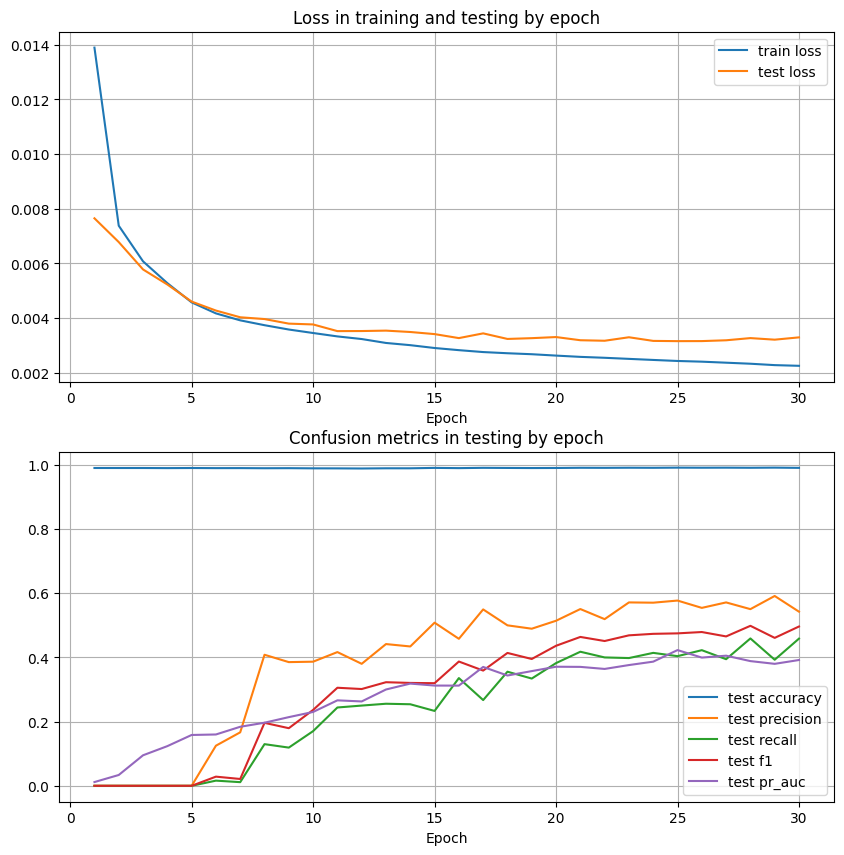

In [12]:
print(f"Training ends {datetime.now().isoformat()}")
for metric in ["accuracy", "precision", "recall", "f1", "mcc", "pr_auc"]:
    if len(model_metrics[f"test_{metric}"]) > 0:
        print(f"Validation {metric}:", model_metrics[f"test_{metric}"][-1])

plot_model_metrics(model_metrics)

In [13]:
os.makedirs(model_output_dir, exist_ok=True)
torch.save(model, f"{model_output_dir}/{pretrained_model_name}.pickle")

In [15]:
warnings.filterwarnings("ignore", category=UserWarning)

test_dataset = dataset = SlideSeperatedCSVDataset(f"{candidates_dataset_dir}/{features_csv_file_name}",
                                                  set(test_slides["slide_name"]))

In [16]:

test_metrics = test_classifier(model, test_dataset, device=device, batch_size=4096)

Testing: 100%|██████████| 4/4 [00:00<00:00,  7.66it/s]


In [17]:
for metric in test_metrics.keys():
    if test_metrics[metric] is not None:
        print(f"Test {metric}:", test_metrics[metric])


Test loss: 0.00765748051344417
Test accuracy: 0.9728844277150425
Test precision: 0.38513513513513514
Test recall: 0.5958188153310104
Test f1: 0.46785225718194257
Test mcc: 0.466028522580855
Test ece: 0.06047268211841583
Test pr_auc: 0.4149021696908077
